In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import cv2
import kornia

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Input Parameters


In [2]:
input_dir = './data'
src_name = 'img1.ppm'  # source image file
dst_name = 'img2.ppm'  # destination image file
learning_rate = 1e-3
num_iterations = 600  
log_interval = 100  # print log every N iterations
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Using ', device)

Using  cpu


In [3]:
def load_image(file_name):
    """Loads the image with OpenCV and converts to torch.Tensor                                      
    """
    assert os.path.isfile(file_name), "Invalid file {}".format(file_name)

    # load image with OpenCV                                                                         
    img = cv2.imread(file_name, cv2.IMREAD_COLOR)

    # convert image to torch tensor                                                                  
    tensor = kornia.image_to_tensor(img).float() / 255. # 1xCxHxW
    return tensor[None]

### Container to hold the homography as a trainable parameter

In [4]:
class MyHomography(nn.Module):
    def __init__(self):
        super(MyHomography, self).__init__()
        self.homo = nn.Parameter(torch.Tensor(3, 3))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.eye_(self.homo)

    def forward(self):
        return torch.unsqueeze(self.homo, dim=0)  # 1x3x3  

### Read images and convert  to tensor

torch.Size([1, 3, 640, 800])
torch.Size([1, 3, 640, 800])


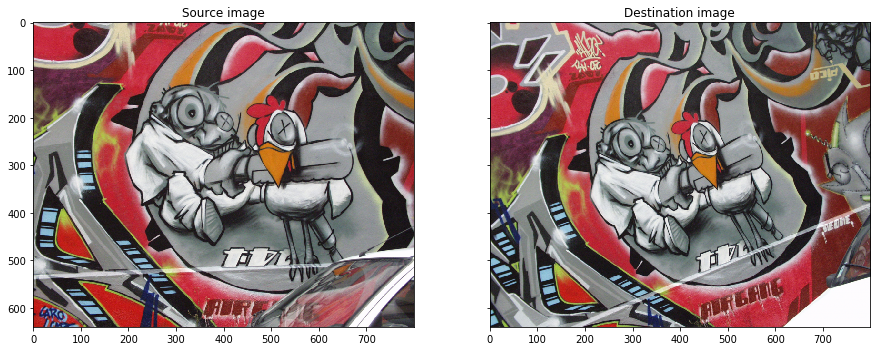

In [5]:
img_src = load_image(os.path.join(input_dir, src_name))
img_dst = load_image(os.path.join(input_dir, dst_name))
print(img_src.shape)
print(img_dst.shape)

%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)

img_src_vis = kornia.tensor_to_image(kornia.bgr_to_rgb(img_src))[0]
img_dst_vis = kornia.tensor_to_image(kornia.bgr_to_rgb(img_dst))[0]

ax1.imshow(img_src_vis)
ax1.set_title('Source image')

ax2.imshow(img_dst_vis)
ax2.set_title('Destination image')
plt.show()

### Initialize the warper and the homography

In [6]:
# create the homography warper
height, width = img_src.shape[-2:]
warper = kornia.HomographyWarper(height, width)
dst_homo_src = MyHomography().to(device)

# create the optimizer
optimizer = optim.Adam(dst_homo_src.parameters(), lr=learning_rate)

# send data to device
img_src, img_dst = img_src.to(device), img_dst.to(device)

### Main optimization loop

This is the loss function to minimize the photometric error:
 $ L = \sum |I_{ref} - \omega(I_{dst}, H_{ref}^{dst}))|$

Train iteration: 0/600	Loss: 0.275021


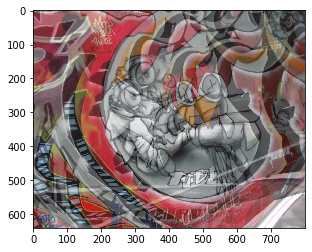

Train iteration: 100/600	Loss: 0.26242


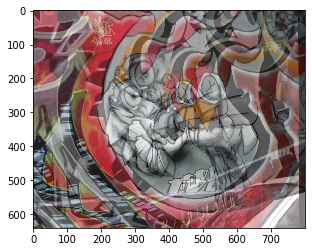

Train iteration: 200/600	Loss: 0.256053


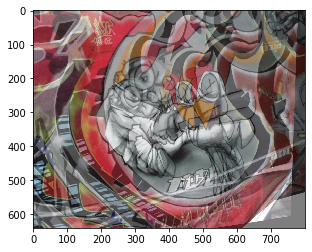

Train iteration: 300/600	Loss: 0.172837


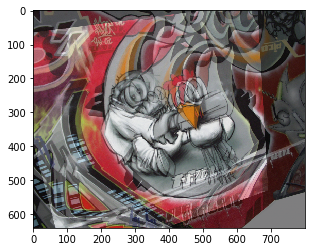

Train iteration: 400/600	Loss: 0.0185626


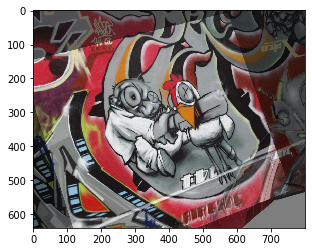

Train iteration: 500/600	Loss: 0.0159184


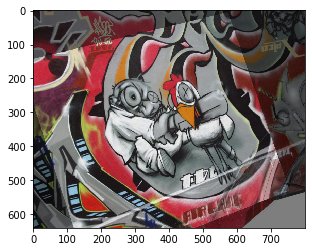

Train iteration: 599/600	Loss: 0.0159194


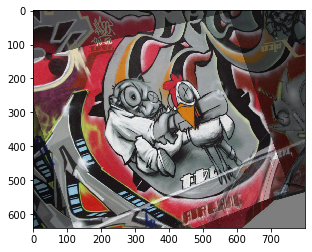

In [7]:
for iter_idx in range(num_iterations):
    # warp the reference image to the destiny with current homography
    img_src_to_dst = warper(img_src, dst_homo_src())

    # compute the photometric loss
    loss = F.l1_loss(img_src_to_dst, img_dst, reduction='none')

    # propagate the error just for a fixed window
    w_size = 100  # window size
    h_2, w_2 = height // 2, width // 2
    loss = loss[..., h_2 - w_size:h_2 + w_size, w_2 - w_size:w_2 + w_size]
    loss = torch.mean(loss)

    # compute gradient and update optimizer parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter_idx % log_interval == 0 or iter_idx == num_iterations-1:
        print('Train iteration: {}/{}\tLoss: {:.6}'.format(
        iter_idx, num_iterations, loss.item()))
        # merge warped and target image for visualization
        img_src_to_dst = warper(img_src, dst_homo_src())
        img_vis = 255. * 0.5 * (img_src_to_dst + img_dst)
        img_vis_np = kornia.tensor_to_image(img_vis)[0]
        plt.imshow(img_vis_np.astype('uint')[:,:,::-1])
        plt.show()